- Student Name: Xiuwen (Alice) Zhu
- Student ID: 1149188
- Course Code: COMP647
- Course Examiner: Professor Don Kulasiri
- Due Date: 03/11/2025

# Project Plan

1.	Feature engineering and feature selection as appropriate to your dataset. Briefly explain and justify what you do using comments in your Python code.

2.	Use appropriate machine learning algorithms (supervised and/or unsupervised) to perform forecasting, classification or clustering tasks with respect to your dataset. Justify why the respective algorithms are selected.
3.	Conduct performance measures in the algorithm evaluations and justify the selected the performance measures would be the most appropriate to evaluate the algorithms chosen. 
4.	Explain how you avoid over fitting and underfitting of the algorithms. 
5.	Perform appropriate explainable AI techniques to discover which features are influencing the predictions


# Research Questions
1. Which subcategories have shown good sales performance in November based on their number of reviews and their occurrence in every November through out the years?

2. How much gross revenue is forcast to be produced from the sub-category 'accessories' by the end of 2016?




# Import the Neccessary Libaries for Machine Learning

In [86]:
import itertools
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns    
import hdbscan  
import os
import shap
import joblib

from matplotlib.patches import Ellipse, Polygon
from scipy import stats
from scipy.spatial.distance import cdist  
from scipy.spatial import ConvexHull       
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_fscore_support
from sklearn.calibration import calibration_curve



# Read Data from CSV

In [87]:
file_path = 'cleaned_amazon_ecommerce.csv' # Define the file path for the dataset.
df = pd.read_csv (file_path)

# View Dataset

In [88]:
df.shape

(9983, 20)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9983 entries, 0 to 9982
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   uniq_id                         9983 non-null   object 
 1   product_name                    9983 non-null   object 
 2   number_of_reviews               9983 non-null   int64  
 3   cleaned_price                   9983 non-null   float64
 4   stock_quantity                  9983 non-null   int64  
 5   stock_condition                 9983 non-null   object 
 6   average_review_rating_out_of_5  9983 non-null   float64
 7   main_category                   9983 non-null   object 
 8   sub_category                    9983 non-null   object 
 9   item_weight_in_kg               9983 non-null   float64
 10  recommended_minimum_age_years   9983 non-null   float64
 11  purchase_month                  9983 non-null   int64  
 12  purchase_year                   99

In [90]:
df = df.drop(columns=['sales'])
# I realised the data in sales column is incorrect.
# It was calculated using price * stock_quantity, which is not the actual sales number. 
# This data is misleading, so I decided to drop this column entirely.

In [91]:
df.shape

(9983, 19)

In [92]:
df.head(2)

,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name,main_category_encoded,sub_category_encoded,seller_name_encoded,month_sin,month_cos
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.6,6.0,4,2014,Amazon.co.uk,17,81,84,8.660254e-01,-0.5
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,2,16.99,3,new,4.5,Hobbies,Model Trains & Railway Sets,0.2,3.0,12,2015,UHD WHOLESALE,17,81,1588,-2.449294e-16,1.0


# Research Question 1

- Which subcategories have shown good sales performance in November based on their number of reviews and their occurrence in every november through out the years?

## Build Models

### KMeans Model

- The research question requires an analysis of sales over the years, so an unsupervised ML model will be used to cluster the sub-categorries.
- A KMeans model will be explored, as it can cluster data points based on feature similarity using the mean of number of reviews and ratings.
- The purpose of this model is to compare its outcome with DBSCAN (the appropriate model for this task), so I can see the difference for myself.

In [93]:
# I want to analyse product sales in November using the previous November data, because this is when festive season shopping starts.
# Although low review count does not means low sale, high review count usually means high sales.
# Therefore, I will use review_count as a proxy for sales.


# Step 1: Filter the data for November purchases only.

nov_df = df[df['purchase_month'] == 11].copy() # Filter the dataframe for November data only throughout the years.
YEARS_RANGE = list(range(2001, 2016))
TOTAL_NOVEMBER_YEARS = len(YEARS_RANGE)

In [ ]:
# Step 2: For each sub_category, aggregate necessary statistics for November data.

grouped_yearly = (
    nov_df
    .groupby(['sub_category', 'purchase_year'])['number_of_reviews']
    .sum()
    .reset_index()
)



# I have explored selecting different features to generate the clusterings for the KMeans model.
# After testing multiple combinations, I settled with number of reviews and purchase years to capture both popularity and consistency of sales.
# The reason for not using purchase_month is because the dataframe is already filtered to November.


In [ ]:
# Step 3: Preprocess features by applying log transformation to the data to reduce skewness and aggregate the data by sub_category.

grouped_yearly['number_of_reviews_log'] = np.log1p(grouped_yearly['number_of_reviews'])
# Apply logarithmic transformation to number_of_reviews to reduce skewness.

agg = grouped_yearly.groupby('sub_category').agg(
    median_reviews_nov=('number_of_reviews_log', 'median'), 
    occurrence_count=('purchase_year', 'nunique') # This counts the number of years in which a subcategory has sales in November.
).reset_index()

agg['prop_nov_years'] = agg['occurrence_count'] / TOTAL_NOVEMBER_YEARS
agg['median_reviews_nov'] = agg['median_reviews_nov'].fillna(0)



# KMean clustering assumes normal distributed data and is sensitive to outliers. 
# So the purpose of using log transformation is to reduce the influence of outliers and standardise the skewed distributions, so that the clustering algorithm can perform effectively.
# I explored using the mean number_of_reviews_log, but found that it caused feature dominance issues in the clustering.
# This may due to some subcategories having extreme high review counts in certain years, which skews the mean.
# However, if I take out those extreme values (outliers), then I am losing important information about the sales patterns/information.
# Some products under certain subcategories may have seasonal spikes in sales, which are important for understanding sales trends.
# Therefore, to avoid losing this information, and not getting affected by the extreme values using mean, I decided to try median.
# Using the median was effective in reducing the influence of extreme values while still capturing the central tendency of review counts.

In [ ]:
# Step 4: Prepare feature matrix.

features = agg[['median_reviews_nov', 'occurrence_count']].values
scaler = StandardScaler() 
features_scaled = scaler.fit_transform(features)



# The median_reviews_nov value are significantly larger than occurrence_count values.
# Therefore, standardisation or normalisation is commonly applied to bring all feature to the same scale.
# Standardissation is to transform the data to all have a standard diviation of 1.
# Normalisation is to scale the data to a range between 0 and 1.
# Given that KMeans model uses distance to group similar data points into clusters, standardisation is more appropriate as it remains the distances between data points.
# Unpon research online, it confirmed that standardisation is often preferred for KMeans clustering.


=== Silhouette and Inertia Results for KMeans (median + standardised) ===
 k   Inertia  Silhouette_Score
 2 74.474169          0.466449
 3 48.658083          0.442839
 4 35.085844          0.427939
 5 27.855673          0.407279
 6 22.131194          0.406087
 7 17.579168          0.423941
 8 14.222836          0.445616
 9 12.549888          0.424119


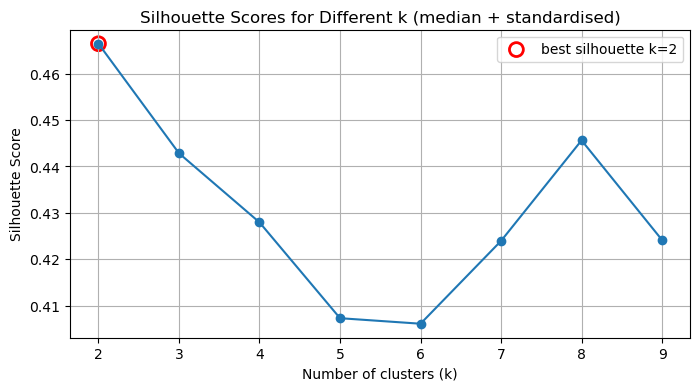

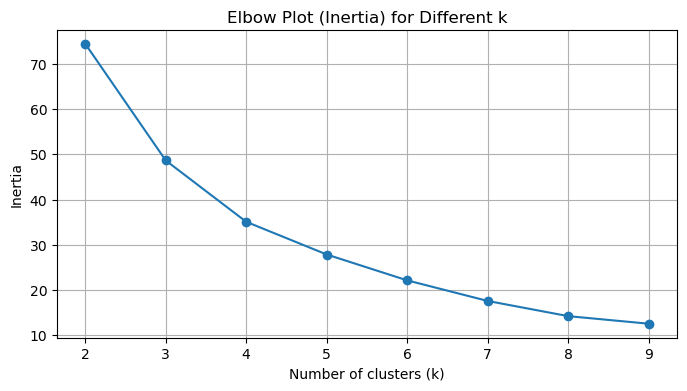

In [ ]:
# Step 5: Evaluate the K values using silhouette score.

inertias = [] 
# An inertia score evaluates the quality of a clustering model. 
# This score is calculated by sum all the squared distances to get the total inertia score for the entire dataset.
# It measures how tightly the data points are clustered around their centroids.
# The score range from 0 to infinity.
# A lower inertia indicates that the data points are closer to their respective cluster centroids, which is desirable.

sil_scores = []
# A silhouette score measures how similar a data point is to its own cluster compared to other clusters.
# The silhouette score ranges from -1 to 1.
# A higher silhouette score (near 1) indicates better-defined clusters, so the highest K is normally chosen.

ks = range(2, 10) 
# Test k values range from 2 to 9 to find the optimal number of clusters.
# The reason that it starts from 2 is that if it is 1, then all data points are in 1 cluster.


for k in ks:
    kmeans_tmp = KMeans(n_clusters=k, random_state=42, n_init=50)
    # n_clusters=k sets the number of clusters.
    # n_init=50 means runs the algorithm will run 50 times with different starting points, and keeping the best solution.

    labels_tmp = kmeans_tmp.fit_predict(features_scaled) 
    # labels_tmp assigns each data point to a cluster.
    # fit_predit is to fit the KMeans model to the scaled data.
    
    inertias.append(kmeans_tmp.inertia_) 
    sil_scores.append(silhouette_score(features_scaled, labels_tmp))
    # Collecting both inertia and silhouette scores for each k.
    # Can't use rely on inertia alone to determine the optimal K. 
    # Best to use both inertia and silhouette scores together to make decision.

silhouette_results = pd.DataFrame({
    "k": list(ks),
    "Inertia": inertias,
    "Silhouette_Score": sil_scores
})

print("\n=== Silhouette and Inertia Results for KMeans (median + standardised) ===")
print(silhouette_results.to_string(index=False))

# Step 5 (a): Plot silhouette
plt.figure(figsize=(8,4))
plt.plot(ks, sil_scores, marker='o')
plt.title("Silhouette Scores for Different k (median + standardised)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
best_k_sil = int(silhouette_results.loc[silhouette_results['Silhouette_Score'].idxmax(), 'k'])
best_sil = silhouette_results['Silhouette_Score'].max()
plt.scatter([best_k_sil], [best_sil], s=100, facecolors='none', edgecolors='red', linewidths=2, label=f'best silhouette k={best_k_sil}')
plt.legend()
plt.show()

# Step 5 (b): Plot inertia (elbow)
plt.figure(figsize=(8,4))
plt.plot(ks, inertias, marker='o')
plt.title("Elbow Plot (Inertia) for Different k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()



# I have explored multiple k values ranges to find the highest silhouette score.
# I have also explored adjusting feature selection and preprocessing steps to improve the clustering results.
# I discovered that when more features are added, more variance and noises presents, does not help with reinforcing the separation between clusters.
# However, it does not mean that adding more features is always bad, it is just this is the case for my data.

In [ ]:
# Step 6: I want to adjust the k value manually to explore different cluster presentations and see how the clustering results vary.

CHOSEN_K = 8  
print(f"\nUsing user-chosen k = {CHOSEN_K} instead of silhouette-best k = {best_k_sil}")



# A different k value will give different clusterting results.
# In most cases, the silhouette-best (highest) k will give the most optimal clustering results.
# However, in my case, the best silhouette k=2 at 0.466449 gives two clusters and it doesn not provide enough breakdown information about the subcategories.
# The research question is to look into the sales patterns of different subcategories in November over the years, so a more detailed clustering breakdown is preferred.
# Based on the combined silhouette and inertia scores, I trust K=8 provides a good balance between cluster detail and quality.
# Also, K=8 not only provide a detailed breakdown of the subcategories it avoided under and over fitting datapoints into clusters by showing reasonable data separations.
# Therefore, I am choosing K=8 for my final clustering analysis.

# One thing I would like to note is that although all the silhouette scores are below 0.5, providing only moderate clustering quality, it is not due to poor feature selection or prepocessing.
# The nature of this data has presence of overlapping characteristics among subcategories, as the sales pattern between many subcategories may not be very distinct, resulting in irregular shaped clusters.
# Such nature of the data is causing the clusters to be less separated and the silhouette scores to be lower, despite many efforts were put into feature selection and engineering.
# However, despite the moderate silhouette scores, the clustering results still provide insightful information about the sales patterns of different subcategories in November over the years.


Using user-chosen k = 8 instead of silhouette-best k = 2


In [99]:
# Step 7: Fit KMean model with chosen k

kmeans = KMeans(n_clusters=CHOSEN_K, random_state=42, n_init=50)
agg['cluster'] = kmeans.fit_predict(features_scaled)
agg['median_reviews_nov_scaled'] = features_scaled[:, 0] # Adding scaled median reviews for November to the agg dataframe, column 0.
agg['occurrence_count_scaled'] = features_scaled[:, 1] # Adding scaled occurrence count to the agg dataframe, column 1.

In [100]:
# Step 8: Convert centroids back to original space and compute cluster scores

centroids_scaled = kmeans.cluster_centers_
# The centroids are are stored in the same scaled feature space for training the KMeans model.
centroids_original = scaler.inverse_transform(centroids_scaled)
# Reverse the scaling back to the original feature, same as how the features were scaled before training.
# The purpose of converting the standardised centroids back to original space (the actual data values) is to make the cluster centroids understandable in the context of the original data.
centroid_df = pd.DataFrame(centroids_original, columns=['median_reviews_nov','occurrence_count'])
# A dataframe is created to store the centroids in original feature space.
centroid_df['cluster'] = centroid_df.index
# Create a cluster column to identify each centroid, showing the meadian number of reviews and occurrence count for each cluster.
centroid_df['score'] = centroid_df['median_reviews_nov'] + centroid_df['occurrence_count'] / TOTAL_NOVEMBER_YEARS
# A scoring metric is created that combines both selected features to rank the clusters.

In [101]:
# Step 9: Label the clusters to human understandable labels in descending order, with 0 being the best.

centroid_df = centroid_df.sort_values('score', ascending=False).reset_index(drop=True)
# Sorting the centroids by their score from highest to lowest, hence it is asending=False.
centroid_df['cluster_label'] = centroid_df.index  
# Label the clusters in descending order, with 0 being the best cluster (highest score).
cluster_label_map = dict(zip(centroid_df['cluster'], centroid_df['cluster_label']))
# A mapping dictionary is created to link the old cluster numbers to new labels, so that cluster 0 is always the best cluster.
agg['cluster_label'] = agg['cluster'].map(cluster_label_map)
# Apply the mapping by aggretating the new cluster label to the main dataframe.
centroid_df['cluster'] = centroid_df['cluster_label']
# Update centroid_df by replacing the old cluster number with the new labels that are human understandable.
centroid_df = centroid_df.drop(columns='cluster_label')
# Drop the cluster_label column.

best_cluster = 0
# Define the best cluster as cluster 0.

In [102]:
# Step 10: Storing outputs.

OUTPUT_SUMMARY_CSV = "november_subcategory_clusters.csv" 
# Define a file name that stores the clustering results.
agg_sorted = agg.sort_values(['cluster_label', 'median_reviews_nov', 'occurrence_count'], ascending=[True, False, False])
# Sort the full dataset by cluster label, then by median reviews and occurrence count within each cluster for better readability.
agg_sorted.to_csv(OUTPUT_SUMMARY_CSV, index=False)
# The output is saved into the defined CSV file, it contains the full clustering results for all sub-categories. No column was added to the original dataframe.
# This would be the final output for data interpretation and analysis. 

print("\nCluster centroids (original units, sorted by score):")
print(centroid_df[['cluster','median_reviews_nov','occurrence_count','score']])
print(f"\nBest-performing cluster (high median reviews & high occurrence): cluster {best_cluster}")
print(f"Saved detailed results to: {os.path.abspath(OUTPUT_SUMMARY_CSV)}")



Cluster centroids (original units, sorted by score):
   cluster  median_reviews_nov  occurrence_count     score
0        0            4.204976          1.400000  4.298310
1        1            3.802775          6.875000  4.261109
2        2            3.370134          4.333333  3.659023
3        3            2.287028          6.300000  2.707028
4        4            2.171965          3.375000  2.396965
5        5            2.126241          1.166667  2.204018
6        6            1.107678          4.000000  1.374345
7        7            0.931136          1.400000  1.024469

Best-performing cluster (high median reviews & high occurrence): cluster 0
Saved detailed results to: /Users/xiuwen/Documents/GitHub/1149188/COMP647/november_subcategory_clusters.csv


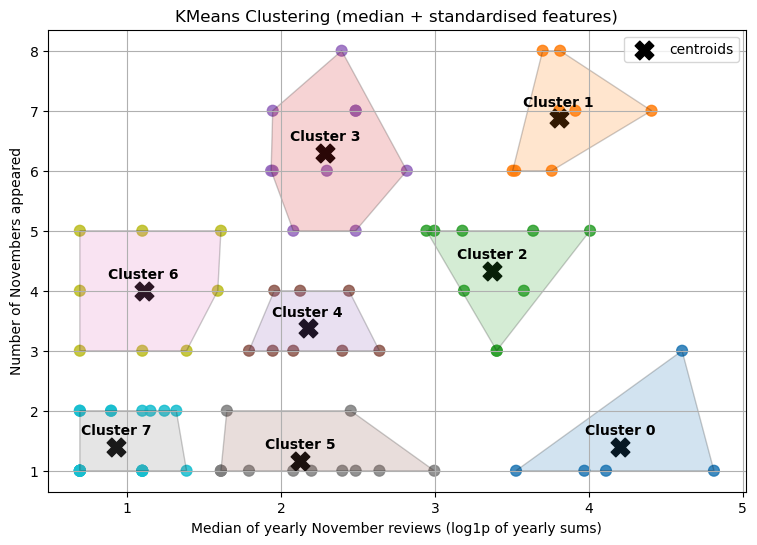

In [ ]:
# Step 11: Plot clusters with cluster labels on centroids.

plt.figure(figsize=(9,6))

plt.scatter(
    agg['median_reviews_nov'], # x-axis: median reviews in November
    agg['occurrence_count'], # y-axis: occurrence count
    c=agg['cluster_label'], 
    cmap='tab10', # colour map for different clusters. The tab10 gives 10 different colours.
    s=60, # Marker size for readability.
    alpha=0.85 # Transparency for visibility.
)

plt.scatter(
    centroid_df['median_reviews_nov'], 
    centroid_df['occurrence_count'], 
    c='black', 
    s=180, # Marker size for the centroid dots.
    marker='X', # Shape of the centroid markers.
    label='centroids'
)

# Step 11 (a): Add a lable to each centroid and draw convex hulls around clusters.
for i, row in centroid_df.iterrows(): # i stands for the index (0,1,2,...), and row contains the centroid data for that index.
    plt.text(
        row['median_reviews_nov'], 
        row['occurrence_count'] + 0.2,  # + 0.2 is a small offset above the centroid so that it does not overlap with the marker.
        f"Cluster {int(row['cluster'])}",
        fontsize=10,
        fontweight='bold',
        ha='center'
    )

for cluster_id in agg['cluster_label'].unique():
    cluster_points = agg[agg['cluster_label'] == cluster_id][['median_reviews_nov', 'occurrence_count']].values
    if len(cluster_points) >= 3:  # ConvexHull needs at least 3 points
        hull = ConvexHull(cluster_points)
        # Draw polygon
        plt.fill(cluster_points[hull.vertices,0], cluster_points[hull.vertices,1], 
                 alpha=0.2, color=plt.cm.tab10(cluster_id), edgecolor='k')


plt.xlabel('Median of yearly November reviews (log1p of yearly sums)')
plt.ylabel('Number of Novembers appeared')
plt.title('KMeans Clustering (median + standardised features)')
plt.grid(True)
plt.legend()
plt.show()



# I wanted to further enhance the cluster visualisation by adding cluster centroid markers and labels.
# Then I also wanted to see the cluster boundaries more clearly.
# I tried using ellipses to outline the clusters, but found that it was not effective, as KMeans assumes the datapoints in the clusters to be ideally normally distributed.
# Given that the clusters are not quite spherical shaped, I tried convex hulls to outline the cluster boundaries and I found it to be more effective.
# With the convex hulls enhacement, it is easier to see the separation between clusters and the overall shape of each cluster.
# The shape of the clusters is hinting the presence of outliers within each cluster.
# This is unavoidable because the nature of this dataset presents outliers, and many of which are important parts of the sales pattern. Whether these outliers should be excluded for decision-making purposes can only be determined by the managerial team.
# Therefore, this explains why the DBSCAN algorithem is more suitable for modeling the answer for this question.

In [104]:
# Step 13:  Print top sub-categories in best cluster

best_subcats = agg[agg['cluster_label'] == best_cluster].sort_values('median_reviews_nov', ascending=False)
print("\nTop sub-categories in the best-performing cluster for November:")
print(best_subcats[['sub_category','median_reviews_nov','occurrence_count']].to_string(index=False))


Top sub-categories in the best-performing cluster for November:
          sub_category  median_reviews_nov  occurrence_count
             Chocolate            4.812184                 1
   Kites & Flight Toys            4.605170                 3
          Garden Tools            4.110874                 1
           Blackboards            3.970292                 1
Schoolbags & Backpacks            3.526361                 1


In [ ]:
# Step 14: Provide detailed listing of sub-categories per cluster

print("\nDetailed sub-category listing per cluster (sorted by median_reviews_nov):")

# Step 14 (a): Sort agg for readability
agg_sorted_clusters = agg.sort_values(['cluster_label', 'median_reviews_nov'], ascending=[True, False])

# Step 14 (b): Loop through each cluster and print a readable table
for cluster_id, group in agg_sorted_clusters.groupby('cluster_label'):
    print(f"\nCluster {cluster_id}") # The f'' means f-string, it is a formatting feature that allows for embbeding variables to directly put inside the strings using the curly braces {}.
    print("-" * 30)
    for _, row in group.iterrows():
        print(f"{row['sub_category']} (median={row['median_reviews_nov']:.3f}, occur={int(row['occurrence_count'])})")



# Although subcategories in Cluster 0 have the highesst median number of reviews, the occurence counts are not so high.
# In comparison, subcategories in Cluster 1 have slightly lower median number of reviews, but it has significantly higher occurence counts.
# As a result, the subcategories in Cluster 1 may be a better proxy for consistent November sales over the years.


Detailed sub-category listing per cluster (sorted by median_reviews_nov):

Cluster 0
------------------------------
Chocolate (median=4.812, occur=1)
Kites & Flight Toys (median=4.605, occur=3)
Garden Tools (median=4.111, occur=1)
Blackboards (median=3.970, occur=1)
Schoolbags & Backpacks (median=3.526, occur=1)

Cluster 1
------------------------------
Accessories (median=4.407, occur=7)
Star Wars (median=3.912, occur=7)
Unknown (median=3.813, occur=8)
Card Games (median=3.807, occur=7)
Hasbro (median=3.759, occur=6)
Toy Vehicles & Accessories (median=3.699, occur=8)
Children's Craft Kits (median=3.521, occur=6)
Science Fiction & Fantasy (median=3.505, occur=6)

Cluster 2
------------------------------
Disney (median=4.007, occur=5)
Toy Trains & Accessories (median=3.638, occur=5)
Banners, Stickers & Confetti (median=3.577, occur=4)
Colouring Pens & Markers (median=3.401, occur=3)
Trivia & Quiz Games (median=3.401, occur=3)
Dice & Dice Games (median=3.188, occur=4)
Jigsaws (median=3.

### DBSCAN Model

- The optimal model for answering Q1.
- DBSCAN algorithm can analyse data into clusters like KMeans, but more robust with handling data with noises.
- Many of the logics learned from building the KMeans model will be similarily applied when creating the DBSCAN model.

[Running DBSCAN for outlier detection]


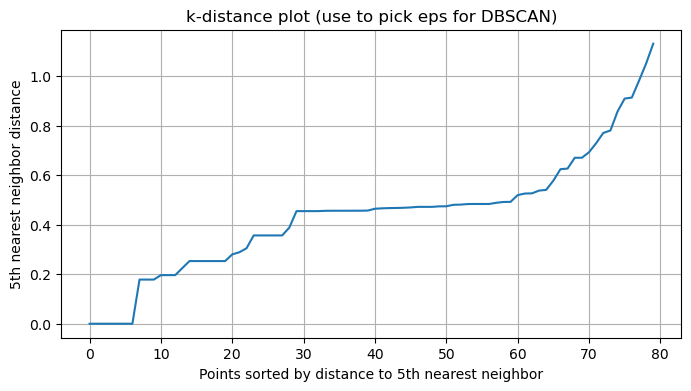

In [ ]:
# Step 1: Preparing the algorithm to detect outliers and adjust the density of clusters.

print("[Running DBSCAN for outlier detection]")

min_samples = 5
# This parameter defines how many data points are needed to form a dense cluster, 5 is a typical default value.
features_scaled = scaler.fit_transform(features) 
# Use same standardised features as KMeans model.
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(features_scaled)
# This is to create a nearest neighbour model to find the nearest data point for the cluster.
# The n_neighbour function tells how many neighbbours/data points are needed to form a dense cluster.
distances, indices = nbrs.kneighbors(features_scaled)
# The 'distances' is the distance arrangement between each data point, that considered to be its nearest neighbours.
# The 'indices' is the corresponding row numbers of those nearest neighbours.
k_distances = np.sort(distances[:, -1])
# This code provides a sorted array of the distances from smallest to largest, that reflects the density of the data.
# The 'distances[:, -1]' extracts the distances of the furtherest data point among the min_samples's nearest neighbour.

plt.figure(figsize=(8,4))
plt.plot(k_distances)
plt.xlabel(f"Points sorted by distance to {min_samples}th nearest neighbor")
plt.ylabel(f"{min_samples}th nearest neighbor distance")
plt.title("k-distance plot (use to pick eps for DBSCAN)")
plt.grid(True)
plt.show()



# The irregular shaped cluster displayed in the KMeans model are the result of outliers.
# Outliers are datapoints that are far from the intra cluster centroids. 
# The DBSCAN model can identify and highlight these outliers, enabling a more in-depth interpretation of the data.
# The k-distance plot helps with identifying the optimal epsilon value that best separates dense clusters from sparse data points.
# This optimal epsilon value lies on the sharp bend, often described as the 'elbow' of the graph. This location is also referred as the point of maximum curvature.

In [ ]:
# Step 2: Run DBSCAN algorithm.

eps_manual = 0.45
# Normally, the elbow point in the k-distance plot is used to suggest the appropriate eps-value.
# The detectd appropriate eps-value in this case is 0.57 and it is overfitting the data points.
# So I changed the syntax to make it manually adjustable, allowing me to explore different eps-value based on visual inspection of the plot and observe the results it generates.

eps_to_use = eps_manual
# Setting up the epsilon value for DBSCAN.
# This value determines the maximum distance between two samples to be considered as neighbours for each intra-cluster.
# eps_manual is to allow for manual adjustment.
print(f"Running DBSCAN with eps={eps_to_use}, min_samples={min_samples}")

db = DBSCAN(eps=eps_to_use, min_samples=min_samples, metric='euclidean')
# Grouping data points that are thats many neigbours, and marks points that appear as outliers (noise).
# Euclidean distance is used to measure how close data points are.
db_labels = db.fit_predict(features_scaled)
# Run DBSCAN on clustering and get the labels for each data point.

Running DBSCAN with eps=0.45, min_samples=5


In [ ]:
# Step 3: Demonstrate the DBSCAN results for analysis.

min_samples_local = 3

agg['dbscan_within_cluster'] = 0  # default (0 = inlier)

for cid in sorted(agg['cluster_label'].unique()):
    cluster_mask = (agg['cluster_label'] == cid)
    X_cluster = features_scaled[cluster_mask]
    if len(X_cluster) < min_samples_local:
        agg.loc[cluster_mask, 'dbscan_within_cluster'] = 0
        continue

    db_local = DBSCAN(eps=eps_manual, min_samples=min_samples_local, metric='euclidean')
    cluster_labels = db_local.fit_predict(X_cluster)
    agg.loc[cluster_mask, 'dbscan_within_cluster'] = cluster_labels  # -1 = outlier

# Step 3 (a): Summary of noise counts per cluster
summary_within = (
    agg.groupby('cluster_label')['dbscan_within_cluster']
       .apply(lambda s: (s == -1).sum())
       .reset_index(name='num_outliers')
)
summary_within['total_points'] = agg.groupby('cluster_label').size().values
summary_within['percent_outliers'] = 100 * summary_within['num_outliers'] / summary_within['total_points']
print("\n=== Outliers per cluster (DBSCAN run within clusters) ===")
print(summary_within.to_string(index=False))



# This step is to run the DBSCAN within each clusters to identify the outliers, using the eps and min_samples values. 
# The set up of the clusters follow the KMeans model logic (using K=8, median and logarithm), where the data are separated into eight groups because this number provides a sufficient breakdown of the subcategories while avoiding under and over fitting issues.

# When I used the reulting eps-value from the k-distance plot (eps=0.57) and the default min_samples value of 5, Clusters 0 and 6 showed 100% outliers, while Cluster 2 has 11.11%.
# Meanwhile, the remaining clusters have 0% outliers.
# This result suggests that only Clusters 0 and 6 have severe irregular Cluster shapes and low datapoint density, whereas Cluster 2 demonstartes minor irregular distribution issues.
# However, this is not entirely true because other clusters also inherently show irregular cluster shapes.
# The combination of eps=0.57 and min_samples=5 is clearly not suitable for the majority of the clusters.
# Therefore, I tried adjusting the eps and min_samples values to improve the DBSCAN results.
# The DBSCAN results appeared reasonable for most clusters when eps=0.45 and min_samples=3 were used.
# Only clusters 4 and 7 were shown to have 0% outliers, which is convencing given their realatively close datapoint distributions.
# The remaining clusters were shown to have outliers at different severity, which is consistent with the distribution of the datapoints at intra-cluster and the resulting irregular shapes of the clusters.
# I trust this tunning approach provides an appropiate balanced result that neither under nor over fits the outliers in the clusters.


=== Outliers per KMeans cluster (DBSCAN run within clusters) ===
 cluster_label  num_outliers  total_points  percent_outliers
             0             2             5         40.000000
             1             2             8         25.000000
             2             4             9         44.444444
             3             7            10         70.000000
             4             0             8          0.000000
             5             2            12         16.666667
             6             2             8         25.000000
             7             0            20          0.000000


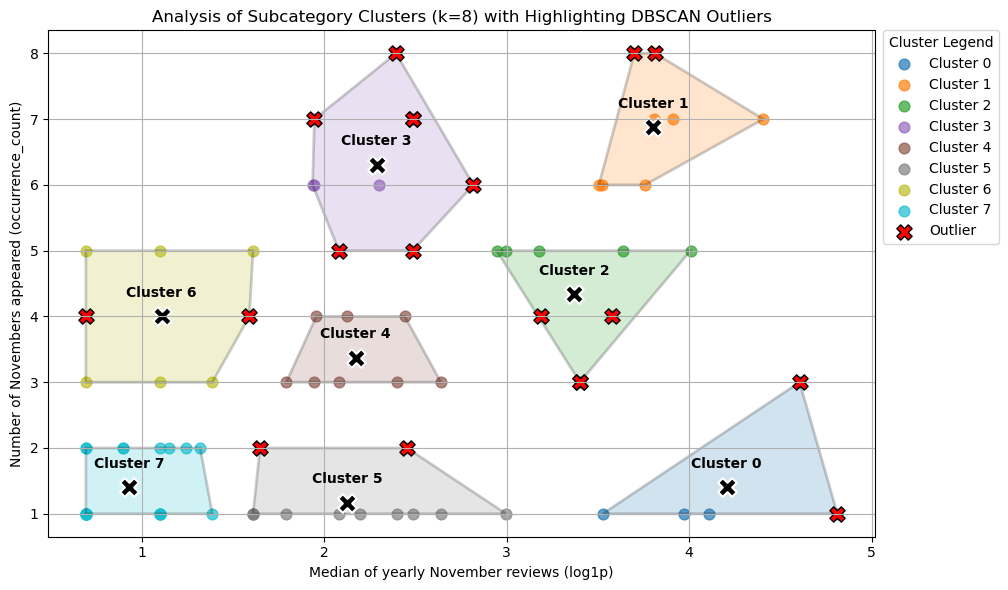

In [ ]:
# Step 4: Highlight the outliers in each cluster

plt.figure(figsize=(12,6))

colors = plt.cm.tab10(np.linspace(0, 1, len(centroid_df)))
# Assign colours to each cluster.
# The plt.cm means colourmap in Matplolib.
# The tab10 means the qualitative colourmap with 10 distinct colour.

for idx, (cluster_id, color) in enumerate(zip(sorted(agg['cluster_label'].unique()), colors)):
    cluster_data = agg[agg['cluster_label'] == cluster_id]
    # Loop through the clusters with its corresponding colour.
    # The (zip(sorted(agg['cluster_label'].unique()), colors) means pair each cluster label with from the colour map.

    plt.scatter(cluster_data['median_reviews_nov'],
                cluster_data['occurrence_count'],
                s=60, color=color, alpha=0.7, label=f'Cluster {cluster_id}')
    # Plot points for the current cluster id.
    
    if len(cluster_data) >= 3:
        points = cluster_data[['median_reviews_nov', 'occurrence_count']].values
        hull = ConvexHull(points)
        polygon = Polygon(points[hull.vertices], 
                          closed=True, 
                          facecolor=color, alpha=0.2, edgecolor='black', lw=2)
        plt.gca().add_patch(polygon)
        # Draw convex hull if cluster has >= 3 data points.
    
    cx = centroid_df.loc[centroid_df['cluster'] == cluster_id, 'median_reviews_nov'].values[0]
    cy = centroid_df.loc[centroid_df['cluster'] == cluster_id, 'occurrence_count'].values[0]
    plt.scatter(cx, cy, color='black', marker='X', s=180, edgecolors='white', linewidths=1.5)
    # Mark centroid with black "X" for obvious identification.

    plt.text(cx, cy + 0.3, f"Cluster {cluster_id}",
             fontsize=10, fontweight='bold', ha='center', color='black')
    # Asign centroid label slightly above the centroid marker for better readability.

if 'dbscan_within_cluster' in agg.columns:
    outliers = agg[agg['dbscan_within_cluster'] == -1]
    if not outliers.empty:
        plt.scatter(outliers['median_reviews_nov'],
                    outliers['occurrence_count'],
                    c='red', edgecolors='black', s=120, marker='X', label='Outlier')
    # Highlight DBSCAN outliers if present to enhance data underrstanding during plot visualisation.

plt.xlabel('Median of yearly November reviews (log1p)')
plt.ylabel('Number of Novembers appeared (occurrence_count)')
plt.title(f'Analysis of Subcategory Clusters (k={CHOSEN_K}) with Highlighting DBSCAN Outliers')

# ✅ Move legend outside the plot (right side)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., frameon=True, title="Cluster Legend")

plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for legend
plt.show()



# In this final plot, the subcategory clusters are visually enhanced with convex hull and DBSCAN detected outliers highlighted in red X markers.
# Each convex hull represents the spread  of the data points within a cluster.
# However, some outliers are presenting inside of the shaded area. 
# This is because the shaded areas represent only visual approximations provided by the convex hull. They are do not correspond to the actual boundary shapes determined by the DBSCAN algorithm.
# Moreover, DBSCAN determines by local neighbourhood density, not the distance from the cluster centroid like KMeans.
# Hence, some outliers may appear within the shaded arae, because they are far from their intra-cluster neighbours, despite being close to the cluster centroid.
# And for datapoints that fall outside of the shaded areas, but not marked as outliers, is because they are close to their intra-cluster neighbours, despite being far from the cluster centroid.


In [ ]:
# Step 5: Summary of sub-category listing per cluster with outliers highlighted.

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
# This is very necessary for presentation, as without this, some coloumns are put on a new line (right below), making it hard to read.

def highlight_outliers(val):
    color = 'red' if val == -1 else 'black' 
    return f'color: {color}'
# Function to highlight outliers in red, to make outliers stand out in the table.

cluster_ids = sorted(agg['cluster_label'].unique())
# Go through each cluster in decending order. 

for cluster_id in cluster_ids:
    cluster_data = agg[agg['cluster_label'] == cluster_id][
        ['sub_category', 'median_reviews_nov', 'occurrence_count', 'dbscan_within_cluster']
    ].sort_values(by='median_reviews_nov', ascending=False)
# Present only the identified columns to help understand the clustering results and answer the research question.
    
    print(f"\nCluster {cluster_id}:\n")
    display(cluster_data.style.applymap(highlight_outliers, subset=['dbscan_within_cluster']))



# Presenting the data output in a numeric format helps make data interpratation more straightforward.
# Each table presents a cluster, listing the grouped subcategories, along with their median number of reviews and their occurence in each November from 2001 to 2016.
# The DBSCAN-detected outliers are highlighted in red and denoted as -1. 
# This DBSCAN output provides a detailed analysis of subcategory sales performance in each November from 2001 to 2016, based on their number of reviews and frequency of occurrence.



Cluster 0:



/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_2549/171146162.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(cluster_data.style.applymap(highlight_outliers, subset=['dbscan_within_cluster']))


,sub_category,median_reviews_nov,occurrence_count,dbscan_within_cluster
14,Chocolate,4.812184,1,-1
39,Kites & Flight Toys,4.605170,3,-1
33,Garden Tools,4.110874,1,0
7,Blackboards,3.970292,1,0
57,Schoolbags & Backpacks,3.526361,1,0



Cluster 1:



/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_2549/171146162.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(cluster_data.style.applymap(highlight_outliers, subset=['dbscan_within_cluster']))


,sub_category,median_reviews_nov,occurrence_count,dbscan_within_cluster
1,Accessories,4.406719,7,1
68,Star Wars,3.912023,7,1
77,Unknown,3.812798,8,-1
10,Card Games,3.806662,7,1
36,Hasbro,3.758760,6,0
74,Toy Vehicles & Accessories,3.699393,8,-1
13,Children's Craft Kits,3.521143,6,0
58,Science Fiction & Fantasy,3.504704,6,0



Cluster 2:



/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_2549/171146162.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(cluster_data.style.applymap(highlight_outliers, subset=['dbscan_within_cluster']))


,sub_category,median_reviews_nov,occurrence_count,dbscan_within_cluster
25,Disney,4.007333,5,0
72,Toy Trains & Accessories,3.637586,5,0
4,"Banners, Stickers & Confetti",3.577308,4,-1
17,Colouring Pens & Markers,3.401197,3,-1
76,Trivia & Quiz Games,3.401197,3,-1
23,Dice & Dice Games,3.188363,4,-1
38,Jigsaws,3.178054,5,0
22,Decorations,2.995732,5,0
18,Costumes,2.944439,5,0



Cluster 3:



/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_2549/171146162.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(cluster_data.style.applymap(highlight_outliers, subset=['dbscan_within_cluster']))


,sub_category,median_reviews_nov,occurrence_count,dbscan_within_cluster
47,Paper & Stickers,2.817395,6,-1
28,Educational Games,2.484907,7,-1
34,Hand Puppets,2.484907,7,-1
45,Model Trains & Railway Sets,2.484907,5,-1
75,Trading Cards & Accessories,2.393746,8,-1
27,Dominoes & Tile Games,2.297560,6,0
15,Collectible Figures & Memorabilia,2.079442,5,-1
50,Pirates,1.945910,7,-1
61,"Slot Cars, Race Tracks & Accessories",1.945910,6,0
53,Ravensburger,1.935601,6,0



Cluster 4:



/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_2549/171146162.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(cluster_data.style.applymap(highlight_outliers, subset=['dbscan_within_cluster']))


,sub_category,median_reviews_nov,occurrence_count,dbscan_within_cluster
20,Crayola,2.639057,3,0
62,Soft Dolls,2.441401,4,1
69,Thomas & Friends,2.397895,3,0
12,Chess,2.124248,4,1
6,Beach Toys,2.079442,3,0
26,Dolls' House Dolls & Accessories,1.956012,4,1
3,Art Sand,1.945910,3,0
60,Shops & Accessories,1.791759,3,0



Cluster 5:



/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_2549/171146162.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(cluster_data.style.applymap(highlight_outliers, subset=['dbscan_within_cluster']))


,sub_category,median_reviews_nov,occurrence_count,dbscan_within_cluster
78,VTech,2.995732,1,0
21,DVD Games,2.639057,1,0
9,Brain Teasers,2.484907,1,0
44,Model Building Kits,2.452637,2,-1
55,Rockers & Ride-ons,2.397895,1,0
30,Farm & Animals,2.197225,1,0
51,Playsets,2.079442,1,0
48,Party Tableware,1.791759,1,0
32,Finger Puppets,1.647918,2,-1
5,Barbie,1.609438,1,0



Cluster 6:



/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_2549/171146162.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(cluster_data.style.applymap(highlight_outliers, subset=['dbscan_within_cluster']))


,sub_category,median_reviews_nov,occurrence_count,dbscan_within_cluster
40,Knights & Castles,1.609438,5,1
0,3-D Puzzles,1.589027,4,-1
24,Dinosaurs,1.386294,3,0
19,Cowboys & Indians,1.098612,3,0
54,Remote Controlled Devices,1.098612,5,1
35,Harry Potter,0.693147,5,1
63,"Sorting, Stacking & Plugging Toys",0.693147,3,0
66,Spinning Tops,0.693147,4,-1



Cluster 7:



/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_2549/171146162.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(cluster_data.style.applymap(highlight_outliers, subset=['dbscan_within_cluster']))


,sub_category,median_reviews_nov,occurrence_count,dbscan_within_cluster
49,Pens & Refills,1.386294,1,1
8,Board Games,1.319529,2,0
46,Painting By Numbers,1.242453,2,0
64,Sound Toys,1.151293,2,0
73,Toy Vehicle Playsets,1.098612,1,1
71,Toy Story,1.098612,2,0
29,Erotic Clothing,1.098612,1,1
67,Sport,1.098612,1,1
42,LeapFrog,1.098612,1,1
70,Tomy,0.895880,2,0


## Answer for Q1

Unsupervised machine learning (ML) models were created using the features including purchase_month, purchase_year, sub_category and number_of_reviews to analyse and compare the results of which subcategories have shown good sale performance in November based on their number of reviews and occurence in every November through out the years recorded in the dataframe. 

KMeans and DBSCAN models were created to explore the answer for Q1. These two models were chosen because they are both unsupervised models capable of cluster data into groups for analysis. The principal difference between the two model is that KMeans assumes the data are evenly distributed, whereas DBSCAN does not. KMeans are not good with handling noises and is weaker at detecting clusters in irregular shapes. In the contrary, DBSCAN performs more robustly in sunch condition. Hence, DBSCAN is the most suitable model to answer this question and the results will be based on the DBSCAN outcome. Although DBSCAN was chosen to model the answer for Q1, I would also like to explore the outcome derived from KMeans. Additionally, I want to retain the steps of the KMeans model exploration for potential logical application in DBSCAN, as well as for result comparison.

In the process of creating the DBSCAN model, eps and min_samples value were tuned manually to avoid over fitting and underfitting of the algorithms. No specific explainable AI technique was used to assess the interpretation of the data, as this research question focuses on analysis rather than prediction. The resulting model provides its own interpretation. The outcome of DBSCAN model suggests that subcategories falling under Cluster 1 have shown good sale performance in November with high occurence rate. These subcategories include accessories, star wars, card games, hasbro, children's craft kits and science fiction and fantasy.

# Research Question 2
- How much gross revenue is forcast to be produced from the sub-category 'accessories' by the end of 2016?


## Build Model

In [150]:
# Research question 2 is a prediction question that requires a supervised model to answer.
# Moreover, this question seeks for a continuous numeric trend based on relationships between features.
# Therefore, a linear regression model is chosen to answer the question. 


# Step 1: Feature enginnering and selection
df['gross_revenue'] = df['number_of_reviews'] * df['cleaned_price']
# Create a new feature called gross_revenue by combining two features together using multiplication.
accessories_df = df[df['sub_category'] == 'Accessories'].copy()
# Filter the dataframe to only 'accessories' from sub_category, then store a copy to the name accessories_df.
# The reason for doing so is because the research question specifically look for trend in 'accessories' from sub-category.
# I initially had trouble extracting the 'accessories' data from the dataframe. 
# After many fail, I remembered python is case sensitive. I changed 'assessories' to 'Accessories', it became successful.


In [151]:
# Step 2: Prepare data for model fitting.
time_ranges = {
    '2008-2015': (2008, 2015),
    '2011-2015': (2011, 2015), 
    '2012-2015': (2012, 2015)
}
# The {} is used to create a dictionary specifying the time ranges I want to study.
# The dataset timeframe range from 2001 to 2016.
# From assignment 2, I analysed that the monthly sale throughout the year was very minimal before 2008.
# Therefore, in this question, I decided to use data from 2008 onwards.
# I initially wanted to study 2008-2015 only.
# However, I decided to add two other time ranges for comparison when I discovered the R2 and MAPE was not optimal for 2008-2015.
# More details are explained in Step 3.

# Step 2(a): Store results.
results = {}

for period_name, (start_year, end_year) in time_ranges.items(): 
# A dictionary is created to provide results looping through each time ranges in the format of start year, end year.
    
    period_df = accessories_df[accessories_df['purchase_year'].between(start_year, end_year)] # Filter data for each time range.
    annual_data = period_df.groupby('purchase_year')['gross_revenue'].sum().reset_index() # Group the data and reset it back to the datafram so that each year has a number of total gross revenue.
        
    X = annual_data['purchase_year'].values.reshape(-1, 1) 
    # The independent variable.
    # The reshape(-1,1) is to change the matrix from a 1 dimensional to a 2 dimensional, because the models require a 2D input matrix for X.
    y = annual_data['gross_revenue'].values
    # The dependent variable.

    model = LinearRegression() # Create this model.
    model.fit(X, y) # Train the model to fit in a best-fitting line between x and y variables.
    y_pred = model.predict(X) # Train the model to forcast gross revenue (y) for the given purchase year (x).
    
    
    
 # Step 2 (b): Calculate metrics
    mae = mean_absolute_error(y, y_pred) 
    # MAE is Mean Absolute Error, a matrice that measure the average absolute difference between the actual and predicted value to evaluate the accuracy of the forcast.
    # MAE value range from 0 to inifity.
    # A lower MAE value represents better performance.
    r2 = r2_score(y, y_pred)
    # R2 is a matrice that determines how well the dependent variable is explained by the independent variable. 
    # R2 value range from 0 to 1.
    # A value that is closer to 1 represents a better prediction fit to the actual data.
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    # MAPE is Mean Absolute Percentage Error, a matrice that measure the average percetage difference between the actual and predicted value.
    # MAPE value range from 0% to infinity.
    # A percetage of < 10% suggests very minor differences between actual and prediction data, indicate excellent prediction accuracy.
    # 10% - 20% suggests a small difference, indicating good prediction accuracy.
    # >50% suggests unreliablility, indicating poor prediction.
    avg_revenue = np.mean(y)
    mae_to_revenue_ratio = (mae / avg_revenue) * 100
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
    # The stats.linregress() is used to compute the statistical parameters of the linear relationship between X and y, in order to determine the statistical significance.
    
    next_year = end_year + 1
    # Identify what is next year.
    # Since the time ranges are set to end at 2015, +1 to the end of year will give 2016.
    next_year_prediction = model.predict(np.array([[next_year]]))[0]
    # Forcast the gross revenue for next year.
    # The (np.array([[next_year]])) is to create a 2D numpy array so that it match's the model's expected form.
    
    results[period_name] = {
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'mae_to_revenue_ratio': mae_to_revenue_ratio,
        'annual_growth_rate': (slope / avg_revenue) * 100,
        'forecast_2016': next_year_prediction,
        'data_points': len(y),
        'revenue_data': y
    }
    # All the calculated results will be stored in the result dictionary in a loop under each 'period name'.



In [152]:
# Step 3: Comparison table consisting all time ranges.
print("\n" + "=" * 100)
# The "\n" means blank line.
# The "=" * 100 means multiply the symbol by 100 times.
print("COMPREHENSIVE MODEL COMPARISON - THREE TIME RANGES")
print("=" * 100)

col1_width = 20
col2_width = 15
col3_width = 15
col4_width = 15
col5_width = 15
col6_width = 15
# Identify the column width.

header = f"{'TIME RANGE':<{col1_width}} {'DATA POINTS':<{col2_width}} {'R²':<{col3_width}} {'MAE':<{col4_width}} {'MAPE':<{col5_width}} {'2016 FORECAST':<{col6_width}}"
print(header)
print("-" * 100)
# Print out a table with the the column name as indicated.

for period_name in ['2008-2015', '2011-2015', '2012-2015']:
    if period_name in results: # The 'if' function ensures the period name inputted in the result will be printed.
        result = results[period_name]
        row = f"{period_name:<{col1_width}} {result['data_points']:<{col2_width}} {result['r2']:<{col3_width}.3f} ${result['mae']:<{col4_width}.0f} {result['mape']:<{col5_width}.1f}% ${result['forecast_2016']:<{col6_width},.0f}"
        print(row)
# The .3f means limit to 3 decimal places for float.
# The .0f means round to integer, no decimal place.
# The ,.0f means add a comma to the thousand place for the integer.
print("-" * 100)


# Step 3 (a): Comparison table continues.
print(f"\n{'TIME RANGE':<{col1_width}} {'MAE/REVENUE %':<{col2_width}} {'ANNUAL GROWTH':<{col3_width}} {'BUSINESS RISK':<{col4_width}} {'DATA QUALITY':<{col5_width}}")
print("-" * 100)

for period_name in ['2008-2015', '2011-2015', '2012-2015']:
    if period_name in results:
        result = results[period_name]
        
        if result['mape'] <= 10:
            risk = "LOW"
        elif result['mape'] <= 20:
            risk = "MODERATE"
        else:
            risk = "HIGH"
         # This part identifies the business risk.
         # Results <= 10 is low risk.
         # 10-20 is moderate risk.
         # Otherwise (>20) is high risk.
            
        if result['mape'] <= 10 and result['r2'] >= 0.8:
            quality = "EXCELLENT"
        elif result['mape'] <= 20 and result['r2'] >= 0.7:
            quality = "GOOD"
        else:
            quality = "POOR"
        # This part identifies data quality.
        # If the MAPE value is <= 10 and the R2 is >= 0.8, then the data quality is excellent.
        # If the MAPE is <=20 and the R2 is >0.7, then the data quality is good.
        # Otherwiase the quality is poor, meaning unreliable.

        row = f"{period_name:<{col1_width}} {result['mae_to_revenue_ratio']:<{col2_width}.1f}% {result['annual_growth_rate']:<{col3_width}.1f}% {risk:<{col4_width}} {quality:<{col5_width}}"
        print(row)

print("=" * 100)



# Initially, I wanted to make the prediction based on the time range of 2008 to 2015, but both the MAE and MAPE were not optimal.
# Especially the MAPE, returned a score of 346.4, which means an extreme difference lies between the prediction and reality.
# Therefore this time range is not reliable.
# I investigated and discovered that although Amazon was created in the mid-1990s, online sales contributed to just above 6% of all retail sales by 2010.
# Hence, data before 2010 is not helpful for the prediction.
# The 2010 to 2012 period represents the hype phase for online shopping. Therefore, by logic, these spike data is unsuitable for forecasting future trend.
# Also, for the time range 2011 to 2015, MAPE value remain not optimal despite significant improvement. MAE and R2 were in good and excellent state, respectively.
# However, I decided to explore further by exluding 2011, as data from the 2011-2012 can be misleading due to being amid of the hype phase. 
# The model using only the 2012 to 2015 data returned a substantial improvement in both MAPE and MAE results. 
# Despite an approximately 6% decrease in the R2 value compared to the model that included 2011, it offers a better balance in the overall validation metrics.
# Therefore, I decided to use data from 2012 to 2015 to provide the prediction for research question 2. 


# Choosing the most appropriate data time range under the supervision of the R2, MAE, and MAPE results was the strategy used to avoid overfitting and underfitting in my linear regression model.


COMPREHENSIVE MODEL COMPARISON - THREE TIME RANGES
TIME RANGE           DATA POINTS     R²              MAE             MAPE            2016 FORECAST  
----------------------------------------------------------------------------------------------------
2008-2015            8               0.869           $1862            346.4          % $18,053         
2011-2015            5               0.929           $1335            47.5           % $21,702         
2012-2015            4               0.874           $1355            11.7           % $20,448         
----------------------------------------------------------------------------------------------------

TIME RANGE           MAE/REVENUE %   ANNUAL GROWTH   BUSINESS RISK   DATA QUALITY   
----------------------------------------------------------------------------------------------------
2008-2015            28.8           % 39.8           % HIGH            POOR           
2011-2015            13.6           % 40.2           % HIGH

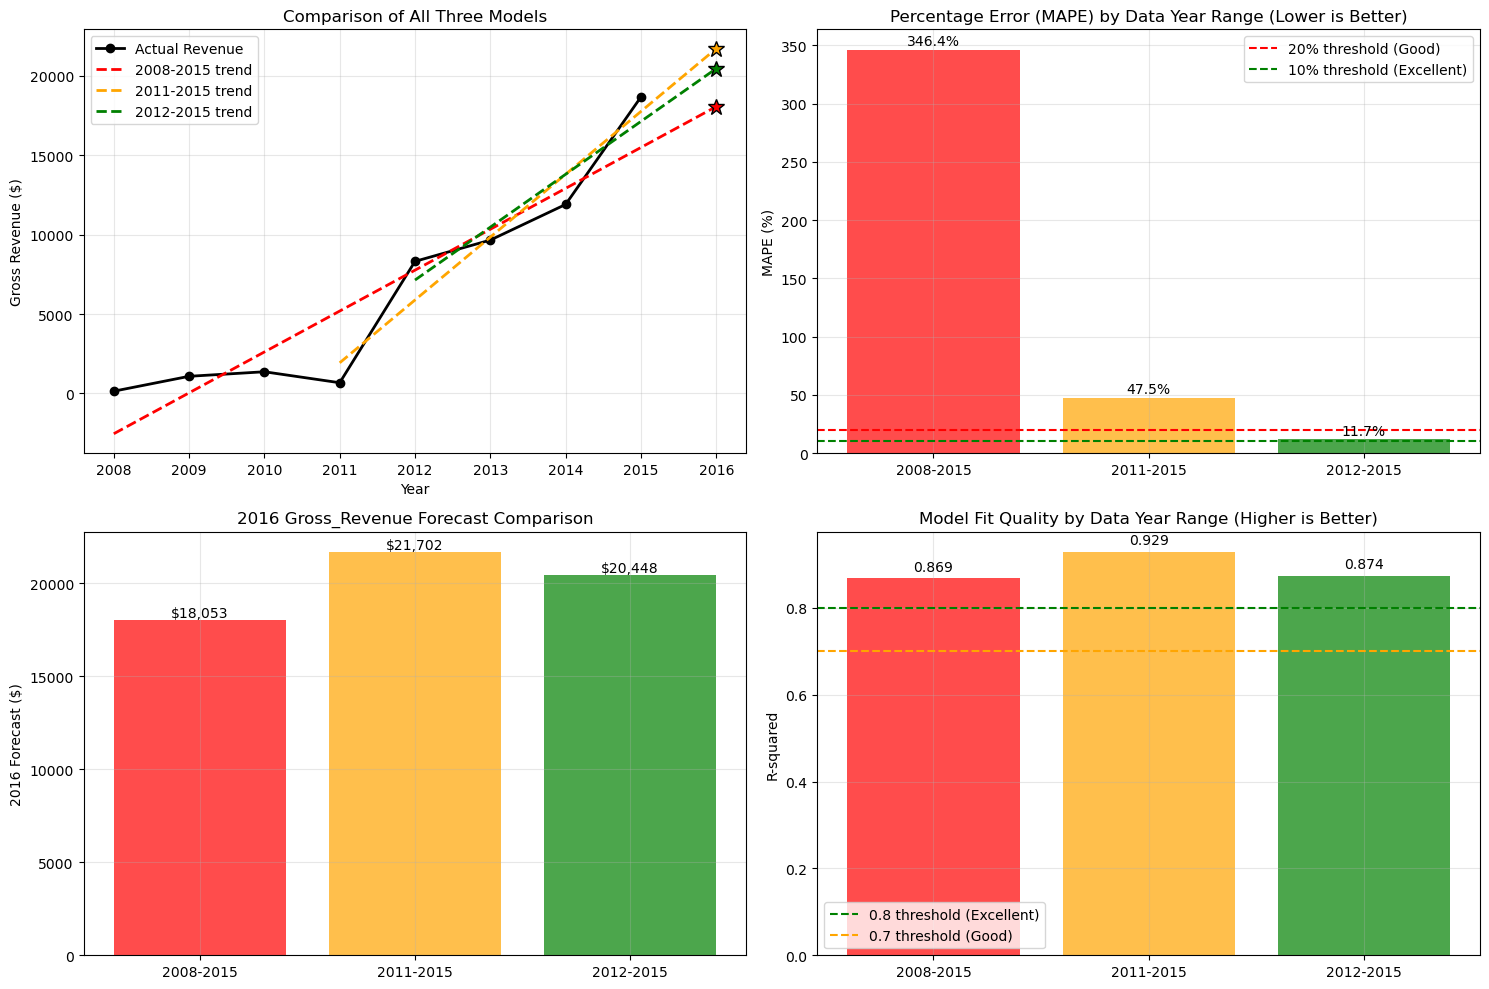

In [153]:
# Step 4: Visualise the models for comparison and decision making.
plt.figure(figsize=(15, 10))

full_data = df[df['sub_category'] == 'Accessories'].copy() # Filter data to accessories from subcategory.
full_annual = full_data.groupby('purchase_year')['gross_revenue'].sum().reset_index() # Group purchase year and annual gross revenue data and put it back into the dataframe.
full_annual = full_annual[full_annual['purchase_year'].between(2008, 2015)] # Get data from 2008 to 2015 to demonstrate the three different explorations.


# Step 4 (a): Plot 1 All models comparison.
plt.subplot(2, 2, 1) # Set the whole figure into multiple subplot setting (2*2 plots), with this plot being the 1st. Therefore, (2,2,1).
plt.plot(full_annual['purchase_year'], full_annual['gross_revenue'], 'ko-', 
# Allocating purchase year as x axis and gross revenue as y axis.
# The ko- breaks down to: k meaning black, o means circle marker and - means line. Together, it is a shorthand for black line with circular markers.
         label='Actual Revenue', linewidth=2, markersize=6)

colors = {'2008-2015': 'red', '2011-2015': 'orange', '2012-2015': 'green'} # Allocating colour for the trend line for each time range model.
for period_name in ['2008-2015', '2011-2015', '2012-2015']: # Loop through the three time range models.
    if period_name in results: # Emphasis a condition that only the stored time range models are plotted.
        result = results[period_name] 
        start_year, end_year = time_ranges[period_name]
        

        extended_years = np.array([start_year, end_year, 2016]).reshape(-1, 1) 
        # Create an extension of the trend lines to show future forecast.
        # .reshape(-1,1) means to change the orginal array a 2D array with the specified data.
        if period_name == '2008-2015': 
            model_data = accessories_df[accessories_df['purchase_year'].between(start_year, end_year)]
            annual_model_data = model_data.groupby('purchase_year')['gross_revenue'].sum().reset_index()
            X_model = annual_model_data['purchase_year'].values.reshape(-1, 1)
            y_model = annual_model_data['gross_revenue'].values
            model_temp = LinearRegression() # Fit a linear regression model.
            model_temp.fit(X_model, y_model) # Fit in the x model (purchase year) and y model (gross revenue) to the linear regression.
            trend_line = model_temp.predict(extended_years) # Fit in the trend lines to predict the extended year (2016).
        else:
            model_data = accessories_df[accessories_df['purchase_year'].between(start_year, end_year)]
            annual_model_data = model_data.groupby('purchase_year')['gross_revenue'].sum().reset_index()
            X_model = annual_model_data['purchase_year'].values.reshape(-1, 1)
            y_model = annual_model_data['gross_revenue'].values
            model_temp = LinearRegression()
            model_temp.fit(X_model, y_model)
            trend_line = model_temp.predict(extended_years)
        
        plt.plot(extended_years, trend_line, '--', color=colors[period_name], # Use dash and allocated colour for the trendlines.
                 linewidth=2, label=f'{period_name} trend')
        plt.plot(2016, result['forecast_2016'], '*', color=colors[period_name], # Pinpoint forcast 2016 results with * and its allocated colour.
                 markersize=12, markeredgecolor='black')

plt.xlabel('Year')
plt.ylabel('Gross Revenue ($)')
plt.title('Comparison of All Three Models')
plt.legend()
plt.grid(True, alpha=0.3)


# Step 4 (b): Plot 2 MAPE comparison.
plt.subplot(2, 2, 2) # Identifying this to be the 2nd plot in the 2*2 plot setting. 
mape_values = [results[period]['mape'] for period in ['2008-2015', '2011-2015', '2012-2015'] if period in results]
periods = ['2008-2015', '2011-2015', '2012-2015']
colors_mape = ['red', 'orange', 'green']
bars = plt.bar(periods, mape_values, color=colors_mape, alpha=0.7) 
# A bar chart is used to show the comparison of the MAPE results of different time ranges.
# The alpha=0.7 is to make the bars slightly transparent.
plt.axhline(y=20, color='red', linestyle='--', label='20% threshold (Good)') # Identifying the threshold.
plt.axhline(y=10, color='green', linestyle='--', label='10% threshold (Excellent)')
plt.ylabel('MAPE (%)')
plt.title('Percentage Error (MAPE) by Data Year Range (Lower is Better)')
plt.legend()
plt.grid(True, alpha=0.3)

for bar, value in zip(bars, mape_values): 
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{value:.1f}%', ha='center', va='bottom')


# Step 4 (c): Plot 3 Forecast comparison.
plt.subplot(2, 2, 3) # Identifying this to be the 3rd plot in the 2*2 plot setting.
forecast_values = [results[period]['forecast_2016'] for period in ['2008-2015', '2011-2015', '2012-2015'] if period in results]
bars = plt.bar(periods, forecast_values, color=colors_mape, alpha=0.7)
plt.ylabel('2016 Forecast ($)')
plt.title('2016 Gross_Revenue Forecast Comparison')
plt.grid(True, alpha=0.3)

for bar, value in zip(bars, forecast_values): # The zip(bars, forecast_values) pairs each bar with corresponidng forecast result in %.
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
    # The plt.text(bar.get_x() + bar.get_width()/2 means, for each bar find the middle point along the x axis.
    # The bar.get_height() + 1 means, place the value labels just a little above the bars.
             f'${value:,.0f}', ha='center', va='bottom')
            # The f' is a formatted literal genearlly called the f-string. 
            # The f-string is an expression that help the syntax to be more concised and simple to read.


# Plot 4 (d) PLot 4 R-squared comparison.
plt.subplot(2, 2, 4) # Identifying this to be the 4th plot in the 2*2 plot setting.
r2_values = [results[period]['r2'] for period in ['2008-2015', '2011-2015', '2012-2015'] if period in results]
bars = plt.bar(periods, r2_values, color=colors_mape, alpha=0.7)
plt.axhline(y=0.8, color='green', linestyle='--', label='0.8 threshold (Excellent)')
plt.axhline(y=0.7, color='orange', linestyle='--', label='0.7 threshold (Good)')
plt.ylabel('R-squared')
plt.title('Model Fit Quality by Data Year Range (Higher is Better)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, r2_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Answer for Q2
- To analyse the gross revenue produced from subcategory 'accessories' by the end of 2016, three different time ranges were compared to avoid over and under fitting issues in the model.
- The analysis suggested that the 2012 to 2015 model provides the most appropriate forcast for 2016.
- The model produced R2, MAPE and MAE results of 0.874, 11.7% and 11.2%, respectively.
- The forcast gross revenue by end of 2016 is $ 20,448, with an annual growth rate of 27.4%.

## Explainable AI (XAI) for the Model

In [154]:
# SHAP will be used to execute the explinable AI process for the linear regression model.
# SHAP is chosen over LIME because the SHAP technique provides more stable explanation and less sensitive to random samplings.
# SHAP uses the game-theoretic algorithm, hence it is known to be more mathematically rigorous than LIME.
# Most importantly, SHAP is capabale of capturing complex feature interactions.


# Step 1: Filter to the data used for the model.
final_accessories_df = accessories_df[accessories_df['purchase_year'].between(2012, 2015)]

annual_data = final_accessories_df.groupby('purchase_year').agg({
    'gross_revenue': 'sum',
    'number_of_reviews': 'sum',
    'cleaned_price': 'mean'
}).reset_index()



# At the beginning, I had trouble making sense of the SHAP evaluation.
# It identified irrelevant features as having high importance and a high impact on gross revenue, which did not aligning with the ML model.
# I doubted the reliability of the ML model created. Wondered whether it should be done the other way round by conduting SHAP first, then create the model.
# Later, I learned that the evaluation was completely off track because all features from the dataframe were included.
# When all features are aggregated, the feature impact on gross revenue and the feature importance ranking were explained globally.
# This means that the features actually being used in the ML model are not being seen as the core.
# The purpose of using SHAP is to explain the features used on the ML model.
# Then, I corrected feature selection by choosing only the features used to create the model and re-ran SHAP.
# In the ML model, 'number_of_reviews' and 'cleaned_price' were grouped together to derive a new feature called 'gross_revenue'.
# The feature 'gross_revenue' should also be treated as one feature, and not being evaluated by its separate compnents in the SHAP model.
# Lastly, the SHAP model improved significantly with features that acutally used in the ML model.

In [155]:
# Step 2: Use features to train the SHAP model.
feature_columns = ['purchase_year'] 
# Features for the SHAP model.
# ALthough subcategory is a crucial feature of this ML model, it does not need to be included here because the data was already filtered to subcategory assessories.
# Also, gross_revenue does not need to be involved here because the feature column is to specify the x-axis features.

X_shap = annual_data[feature_columns]
y_shap = annual_data['gross_revenue']
# Consistetnt to the ML model.

shap_model = LinearRegression()
shap_model.fit(X_shap, y_shap) 
# Train the SHAP model.

print(f"R² Score: {shap_model.score(X_shap, y_shap):.3f}")
print(f"Coefficient: {shap_model.coef_[0]:.2f}")

R² Score: 0.874
Coefficient: 3327.61



1. SHAP Feature Impact on Gross Revenue


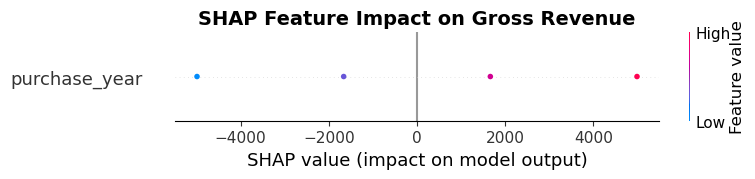


2. SHAP Feature Importance Ranking


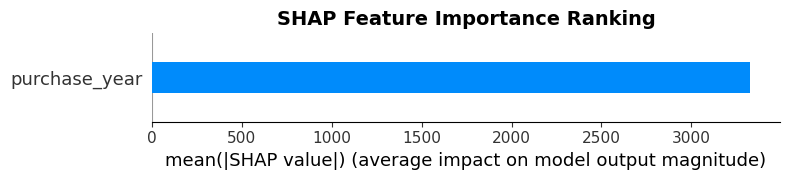


3. Individual Purchase Year Prediction Explanations


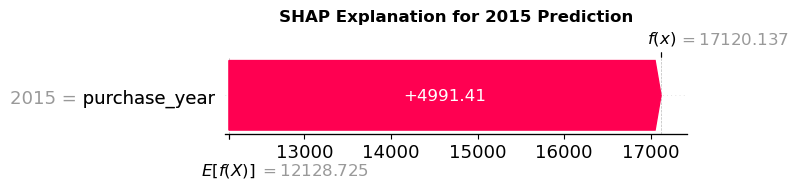

In [156]:
# Step 3: Run and visualise the SHAP interpretation models.
explainer = shap.Explainer(shap_model, X_shap) 
# Initiate SHAP explainer on the 'shap_model', which is the linear regression model. 
# The x_shap is the testing feature that needs to be explianed.
shap_values = explainer(X_shap) 
# Run the explainer to get SHAP values that explain the contribution of the feature to the prediction.


# Step 3 (a): SHAP Summary Plot
print("\n1. SHAP Feature Impact on Gross Revenue")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_shap, show=False)
plt.title("SHAP Feature Impact on Gross Revenue", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
# This plot summarises the impact of purchase year to gross revenue as time advances.


# Step 3 (b): SHAP Bar Plot
print("\n2. SHAP Feature Importance Ranking")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
plt.title("SHAP Feature Importance Ranking", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
# This plot summarises the importance of purchase year to gross revenue.


# Step 3 (c): Individual Purchase Year Prediction Explanations 
print("\n3. Individual Purchase Year Prediction Explanations")
plt.figure(figsize=(12, 4))
shap.plots.waterfall(shap_values[-1], max_display=10, show=False)
plt.title(f"SHAP Explanation for {X_shap.iloc[-1]['purchase_year']} Prediction", 
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()
# This plot summarises the gross revenue prediction for 2015.


In [157]:
# Step 4: Visualise SHAP interpretation in numeric form.
print("\n" + "="*60)
print(" SHAP INTERPRETATION of ACTUAL vs PREDICTION REVENUE PATTERN")
print("="*60)


# Step 4 (a): Checking what the model has learned from the data.
print(f"\nMODEL COEFFICIENTS:")
coefficients = pd.DataFrame({
    'feature': X_shap.columns, 
    'coefficient': shap_model.coef_
})
print(coefficients)
# The coefficient value provides indication of how much the dependent variable (gross_revenue) is expected to change when the 'feature' increases to the next data point.


# Step 4 (b): # Checking the actual and predicted annual gross revenue.
print(f"\nACTUAL vs PREDICTIONS:")
annual_data['predicted'] = shap_model.predict(X_shap)
for i, row in annual_data.iterrows():
    print(f"Year {int(row['purchase_year'])}: Actual = ${row['gross_revenue']:,.0f}, "
    # A f-string is used.
    # The {int(row['purchase_year'])} means convert the purchase year into integer.
    # Format the revenue values in currency style with commas (,) and no decimal places (.0f).
          f"Predicted = ${row['predicted']:,.0f}")


# Step 4 (c): Checking the correlation between purchase year and actual gross revenue. 
print(f"\nCORRELATION WITH REVENUE:")

corr = annual_data['purchase_year'].corr(annual_data['gross_revenue'])
print(f"purchase_year: {corr:.3f}")




 SHAP INTERPRETATION of ACTUAL vs PREDICTION REVENUE PATTERN

MODEL COEFFICIENTS:
         feature  coefficient
0  purchase_year     3327.608

ACTUAL vs PREDICTIONS:
Year 2012: Actual = $8,312, Predicted = $7,137
Year 2013: Actual = $9,652, Predicted = $10,465
Year 2014: Actual = $11,895, Predicted = $13,793
Year 2015: Actual = $18,656, Predicted = $17,120

CORRELATION WITH REVENUE:
purchase_year: 0.935


## Conclusion for Q2
The SHAP analysis summarised that the feature had a high impact on the annual gross revenue, with an importance ranking showing a coefficient of 3327.608 and a positive impact direction in the 2015 forecast of $4,991.41.

In otherwords, the SHAP model explains that the annual gross revenue growth is $3327.608 based on the time range and features used for the ML model. According to the ML model, the predicted gross revenue for 2015 is $17,120. This value is derived from the E[f(x)]= $12,128.75 (the average gross revenue of the entire time range) plus the increased gross revenue of $4991.41 in 2015, resulting in a total prediction of $17,120. The model learned from the data that higher gross revenue tends to be received as time progresses. This argument is further supported by a high correlation score of 0.935 between purchase year and aactual annual gross revenue, reflecting a highly positive growth trend where gross revenue consistently increases more optimistically as each year advances, in both actual and prediction occasions.

Based on the SHAP summary presented above, the 2015 actual gross revenue ($18,656) is higher than the predicted gross revenue ($17,120) by $1,536, suggesting that the ML model showing an under prediction of 8.2%. The R2 for the trendline in the ML model is 0.874, meaning it has 87.4% accuracy and allows for 12.6% of forcasting error. Given that the difference between the actual value and predicted value is below the allowed forcasting error, the accuracy is aligning with the R2 generated by the ML model. In conclusion, the SHAP analysis explains that the ML model is producing reasonable and reliable results.